From a management perspective, the predictive accuracy of models must be weighed against the costs of model development and implementation. The following analysis will compare two methods leveraging random forest classification on the MINIST dataset 1) with all expantory variables, and 2) with a reduced set of explantory variables. At the end, I will recommend which approach should be used when handling the data. 

In [1]:
# code from exploring-mnist-v001.py
# seed value for random number generators to obtain reproducible results
RANDOM_SEED = 1
RANDOM_SEED_MODEL = 9999

# import base packages into the namespace for this program
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import csv
import time

# visualization utilities
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages  # plot to pdf files


In [2]:
# code from exploring-mnist-v001.py for  displaying observations/handwritten digits
def plot_digits(instances, images_per_row = 10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis('off')



In [3]:
# Code from: https://github.com/ageron/handson-ml/issues/301

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)

In [4]:
# Code from: https://github.com/ageron/handson-ml/issues/301
# fetch_ml does not return the exact same dataset as `fetch_mldata()` did
# targets are now strings instead of unsigned 8-bit integers, 
# also returns the unsorted MNIST dataset, whereas `fetch_mldata()` returned the dataset sorted by target
# (the training set and the test set were sorted separately). 
# code below to sort the dataset using the following function:

def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target \
                                    in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target \
                                    in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')

In [5]:
# define arrays from the complete data set
mnist_X, mnist_y = mnist['data'], mnist['target']

In [6]:
# show stucture of numpy arrays
# 70,000 observations, 784 explanatory variables/features
# features come from 28x28 pixel displays
# response is a single digit 0 through 9
print('\n Structure of explanatory variable array:', mnist_X.shape)
print('\n Structure of response array:', mnist_y.shape)

# note the sequential organization of the MNIST data with index plot
# route plot to external pdf file


 Structure of explanatory variable array: (70000, 784)

 Structure of response array: (70000,)


In [7]:
with PdfPages('plot-mnist-index-plot.pdf') as pdf:
    fig, axis = plt.subplots()
    axis.set_xlabel('Sequence/Index number within MNIST Data Set')
    axis.set_ylabel('MNIST Digit')
    plt.title('Index Plot of MNIST Data Set')
    plt.plot(mnist_y[:,])
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()
    
    

# summarize the sequential structure of the MNIST data
# target/label and index values for the observations
# the first 60 thousand observations are often used as training data        
# they cover the ten digits... aranged in order... that is, zeros come
# before ones, ones before twos, and so on
# but the observed digit frequencies are unequal    
# examine the frequency distributions for the digits using pandas DataFrame
# the first 60 thousand observations are often used as training data    
mnist_y_0_59999_df = pd.DataFrame({'label': mnist_y[0:59999,]}) 
print('\nFrequency distribution for 60,000 observations (for model building)')
print(mnist_y_0_59999_df['label'].value_counts(ascending = True))   
    


Frequency distribution for 60,000 observations (for model building)
5    5421
4    5842
8    5851
6    5918
0    5923
9    5948
2    5958
3    6131
7    6265
1    6742
Name: label, dtype: int64


In [8]:
# the last 10000 observations cover the ten digits
# these are often used as test data
# digits are arranged in order but the frequencies are unequal     
mnist_y_60000_69999_df = pd.DataFrame({'label': mnist_y[60000:69999,]}) 
print('\nFrequency distribution for last 10,000 observations (holdout sample)')
print(mnist_y_60000_69999_df['label'].value_counts(ascending = True))   

# in selecting handwritten digits to represent,
# we will randomly sample from digit representations
from sklearn.utils import resample


Frequency distribution for last 10,000 observations (holdout sample)
5     892
6     958
8     974
0     980
4     982
9    1008
3    1010
7    1028
2    1032
1    1135
Name: label, dtype: int64


In [9]:
# display example data from the 28x28 pixel displays 
# ten-page pdf file, 100 digit realizations on each page
# using examples from the full MNIST data set
# 
# we customize the location within the subplot for each page using GridSpec
# see matplotlib documentation: http://matplotlib.org/users/gridspec.html  
# begin by showing samples from the model building data (first 60000 observations)  
with PdfPages('plot-mnist-handwritten-digits-model-building-data.pdf') as pdf:
    for idigit in range(0,10):
        # print('\nworking on digit', idigit)
        
        # identify the index values from the first 60000 observations
        # that have the label equal to a specific digit (idigit)
        idigit_indices = \
            mnist_y_0_59999_df.index[mnist_y_0_59999_df.label == idigit]
        # obtain indices for 100 randomly sampled observations for this digit    
        show_indices = resample(idigit_indices, n_samples=100, 
                                replace = False, 
                                random_state = RANDOM_SEED).sort_values()       
        plt.figure(0)
        plt.suptitle('Examples of MNIST Data for Digit ' + str(idigit))
        # define beginning and ending row index for this digit
        # generate ten rows of ten digits each
        for j in range(0,10):
            row_begin_index = j * 10
            row_end_index = row_begin_index + 10
            # print('row begin',row_begin_index, 'row_end', row_end_index)
            this_row_indices = show_indices[row_begin_index:row_end_index]
            
            example_images = np.r_[mnist_X[this_row_indices]]
            # print(mnist_y[this_row_indices,])
            plt.subplot2grid((10,1), (j,0), colspan=1)
            # plot ten digits per row using user-defined function
            plot_digits(example_images, images_per_row=10)
            row_begin_index = row_end_index + 1
        pdf.savefig()  
        plt.close()   

# also show samples from the holdout data (last 10000 observations)  
with PdfPages('plot-mnist-handwritten-digits-holdout-data.pdf') as pdf:
    for idigit in range(0,10):
        # print('\nworking on digit', idigit)
        
        # identify the index values from the first 60000 observations
        # that have the label equal to a specific digit (idigit)
        idigit_indices = 60000 + \
        mnist_y_60000_69999_df.index[mnist_y_60000_69999_df.label == idigit]
        # obtain indices for 100 randomly sampled observations for this digit    
        show_indices = resample(idigit_indices, n_samples=100, 
                                replace = False, 
                                random_state = RANDOM_SEED).sort_values()       
        plt.figure(0)
        plt.suptitle('Examples of MNIST Data for Digit ' + str(idigit))
        # define beginning and ending row index for this digit
        # generate ten rows of ten digits each
        for j in range(0,10):
            row_begin_index = j * 10
            row_end_index = row_begin_index + 10
            # print('row begin',row_begin_index, 'row_end', row_end_index)
            this_row_indices = show_indices[row_begin_index:row_end_index]
            
            example_images = np.r_[mnist_X[this_row_indices]]
            # print(mnist_y[this_row_indices,])
            plt.subplot2grid((10,1), (j,0), colspan=1)
            # plot ten digits per row using user-defined function
            plot_digits(example_images, images_per_row=10)
            row_begin_index = row_end_index + 1
        pdf.savefig()  
        plt.close()    
        

example of output to review the data being used:
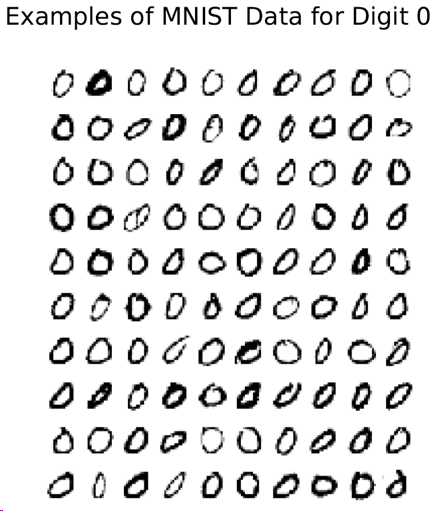

(1) Begin by fitting a random forest classifier using the full set of 784 explanatory variables and the model development set of 60,000 observations. Record the time it takes to fit the model and evaluate the model on the holdout data. Assess classification performance using the F1 score, which is the harmonic mean of precision and recall.

In [10]:
# split dataset into training = 60,000 observations and holdout = 10,000 observations
X_train, X_test, y_train, y_test = mnist_X[: 60000], mnist_X[ 60000:], \
                                  mnist_y[: 60000], mnist_y[ 60000:]

In [11]:
#review shape of data
X_train.shape

(60000, 784)

In [12]:
#review shape of data
X_test.shape


(10000, 784)

In [13]:
#review shape of data
y_train.shape


(60000,)

In [14]:
#review shape of data
y_test.shape

(10000,)

In [15]:
#shuffle the training set so it includes all numbers 0-9
np.random.seed(RANDOM_SEED)
np.random.shuffle(X_train)

np.random.seed(RANDOM_SEED)
np.random.shuffle(y_train)

In [16]:
# specify model
rnd_clf = RandomForestClassifier (n_estimators = 500, max_leaf_nodes = 16, n_jobs=-1)

In [17]:
start_time = time.clock() #start timing
rnd_clf.fit(X_train, y_train) #fit random forest classifier

#predict on holdout data
y_pred_rf = rnd_clf.predict( X_test)

#compute f1 score to evaluate the model
rnd_clf_f1score = f1_score(y_test, y_pred_rf, average=None)

end_time = time.clock()

runtime = end_time - start_time  # seconds of wall-clock time

In [18]:
print ('Total time to fit and evaluate random forest classifier:', runtime)
print('\nf1 score:', rnd_clf_f1score)

Total time to fit and evaluate random forest classifier: 44.133578684167745

f1 score: [0.90900474 0.91213731 0.84439939 0.79037483 0.82211789 0.62857143
 0.86082474 0.86272641 0.81052067 0.78574734]


(2) Execute principal components analysis (PCA) on the full set of 70,000, generating principal components that represent 95 percent of the variability in the explanatory variables. The number of principal components in the solution should be substantially fewer than the 784 explanatory variables. Record the time it takes to identify the principal components. 

In [19]:
# use whole dataset for PCS
X1_train, X1_test, y1_train, y1_test = mnist_X[: 70000], mnist_X[ : 70000],\
                                        mnist_y[: 70000], mnist_y[: 70000]

In [20]:
#review shape of data
X1_train.shape

(70000, 784)

In [21]:
#review shape of data
X1_test.shape

(70000, 784)

In [22]:
#review shape of data
y1_train.shape

(70000,)

In [23]:
#review shape of data
y1_test.shape

(70000,)

In [24]:
#shuffle the training set so it includes all numbers 0-9
np.random.seed(RANDOM_SEED)
np.random.shuffle(X1_train)

np.random.seed(RANDOM_SEED)
np.random.shuffle(y1_train)

In [25]:
start_time_PCA = time.clock() #start timing
pca = PCA( n_components = 0.95) #95% variance
pca.fit(X1_train)
X1_PCA = pca.transform(X1_train)

end_time_PCA = time.clock()

runtime_PCA = end_time_PCA - start_time_PCA  # seconds of wall-clock time

In [26]:
X1_PCA.shape

(70000, 154)

Applying PCA to full dataset of 70,000 observatoons reduces the 784 explanatory variables down to 154 explanatory variables.

In [27]:
print ('Total time to identify principal components:', runtime_PCA)

Total time to identify principal components: 14.184551571807447


(3) Using the identified principal components from step (2), use the first 60,000 observations to build another random forest classifier. Record the time it takes to fit the model and to evaluate the model on the holdout data (the last 10,000 observations). Assess classification performance using the F1 score, which is the harmonic mean of  precision and recall.

In [32]:
# split dataset into training = 60,000 observations and holdout = 10,000 observations
X2_train, X2_test, y2_train, y2_test = X1_PCA[:60000], X1_PCA[ 60000:],\
                                       mnist_y[: 60000],mnist_y[ 60000:]

In [33]:
#review shape of data
X2_train.shape

(60000, 154)

In [34]:
#review shape of data
X2_test.shape

(10000, 154)

In [35]:
#review shape of data
y2_train.shape

(60000,)

In [36]:
#review shape of data
y2_test.shape

(10000,)

In [39]:
#shuffle the training set so it includes all numbers 0-9
np.random.seed(RANDOM_SEED)
np.random.shuffle(X2_train)

np.random.seed(RANDOM_SEED)
np.random.shuffle(y2_train)

In [37]:
# specify model
rnd_clf_PCA = RandomForestClassifier (n_estimators = 500, max_leaf_nodes = 16, n_jobs=-1)

In [40]:
start_time_RFC_PCA = time.clock() #start timing
rnd_clf_PCA.fit(X2_train, y2_train) #fit random forest classifier

#predict on holdout data
y_pred_rf_PCA = rnd_clf_PCA.predict(X2_test)

#compute f1 score to evaluate the model
rnd_clf_PCA_f1score = f1_score(y2_test, y_pred_rf_PCA, average=None)

end_time_RFC_PCA = time.clock()

runtime_RFC_PCA = end_time_RFC_PCA - start_time_RFC_PCA  # seconds of wall-clock time

In [41]:
print ('Total time to fit and evaluate random forest classifier with PCA:', runtime_RFC_PCA)
print('\nf1 score:', rnd_clf_PCA_f1score)

Total time to fit and evaluate random forest classifier with PCA: 159.2116431277259

f1 score: [0.88900204 0.90753425 0.81555334 0.77119016 0.82233503 0.68102849
 0.86412788 0.84173387 0.78009142 0.76348548]


In [42]:
total_PCA_time = runtime_PCA + runtime_RFC_PCA
print ('Total time to run PCA and fit and evaluate random forest classifier with PCA:',\
       total_PCA_time)

Total time to run PCA and fit and evaluate random forest classifier with PCA: 173.39619469953334


(4) Compare test set performance across the two modeling approaches: original 784-variable model versus the 95-percent-PCA model. Also evaluate the time required to perform (1) versus the time required to perform (2) and (3) together. Ensure that accurate measures are made of the total time it takes to execute each of the modeling approaches in training the models. 

- Assessing the performance of the two modeling approaches with the F-scores, we see that for every digit - with the exception of digits 5 and 6 -  that the random forest classifier using all explanatory variables is more accurate than the random forest classifer after PCA is used:


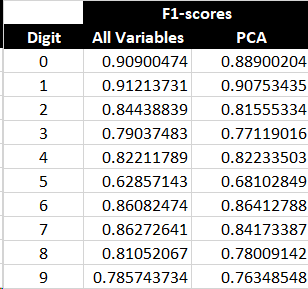 


- When reviewing the time needed to perfrom the requirements, it took less time to use all explanatory variables:
    - The time it took to run the random forest classifer with all variables was: 14.18 seconds 
    - The total time to run PCA and fit and evaluate random forest classifier with PCA was: 173.39 seconds

    - This appears to be an odd result since presumably, it would take less computing power and time to use a model with fewer variables

Applied a training-and-test regimen. 

In [49]:
#code from #Géron, Aurélien. Hands-On Machine Learning with Scikit-Learn
# and TensorFlow (p. 85). O'Reilly Media. Kindle Edition. 
start_time2 = time.clock() #start timing
from sklearn.model_selection import StratifiedKFold 
from sklearn.base import clone 
skfolds = StratifiedKFold( n_splits = 3, random_state = RANDOM_SEED) 
for train_index, test_index in skfolds.split( X_train, y_train): 
        clone_rnd_clf_PCA = clone(rnd_clf_PCA) 
        X_train_folds2 = X2_train[ train_index] 
        y_train_folds2 = y2_train[ train_index] 
        X_test_fold2 = X2_train[ test_index] 
        y_test_fold2 = y2_train[ test_index] 
        
        clone_rnd_clf_PCA.fit( X_train_folds2, y_train_folds2) 
        y_pred2 = clone_rnd_clf_PCA.predict( X_test_fold2)
        score = f1_score(y_test_fold2, y_pred2, average=None)
         
        print('\nf1 score:', score)
        
end_time_2 = time.clock()

runtime_2= end_time_2 - start_time2  # seconds of wall-clock time

print (runtime_2)



f1 score: [0.8964113  0.90838876 0.81417245 0.77209914 0.79471545 0.65415929
 0.84894186 0.84523261 0.75414013 0.73221076]

f1 score: [0.89354005 0.90484282 0.81346495 0.75219158 0.80565553 0.62664298
 0.86329176 0.84764543 0.72755498 0.74677886]

f1 score: [0.89368259 0.90539683 0.80191532 0.76993664 0.81082488 0.66689373
 0.86051661 0.84688441 0.7734355  0.75226425]
304.6645104143645


In [51]:
#code from #Géron, Aurélien. Hands-On Machine Learning with Scikit-Learn
# and TensorFlow (p. 85). O'Reilly Media. Kindle Edition. 
start_time_RFC_PCA2 = time.clock() #start timing

from sklearn.model_selection import StratifiedKFold 
from sklearn.base import clone 
skfolds = StratifiedKFold( n_splits = 3, random_state = RANDOM_SEED) 
for train_index, test_index in skfolds.split( X2_train, y2_train): 
        clone_rnd_clf_PCA = clone(rnd_clf_PCA) 
        X_train_folds2 = X2_train[ train_index] 
        y_train_folds2 = y2_train[ train_index] 
        X_test_fold2 = X2_train[ test_index] 
        y_test_fold2 = y2_train[ test_index] 
        
        clone_rnd_clf_PCA.fit( X_train_folds2, y_train_folds2) 
        y_pred2 = clone_rnd_clf_PCA.predict( X_test_fold2)
        score = f1_score(y_test_fold2, y_pred2, average=None)
         
        print('\nf1 score:', score)
        
end_time_RFC_PCA2 = time.clock()

runtime_RFC_PCA2 = end_time_RFC_PCA2 - start_time_RFC_PCA2  # seconds of wall-clock time

print ('Total time:', runtime_RFC_PCA2)


f1 score: [0.89662231 0.91213749 0.80933466 0.76606795 0.79601736 0.64388869
 0.84522934 0.83773238 0.75213675 0.74004809]

f1 score: [0.88606939 0.90641654 0.80450358 0.75374732 0.80915638 0.6405868
 0.85992218 0.84708625 0.72202532 0.75358471]

f1 score: [0.89233153 0.90418526 0.8        0.76366805 0.8061117  0.67559217
 0.86336925 0.84790698 0.75918367 0.73489583]
Total time: 296.55112892061516


From a management perspective, the predictive accuracy of models must be weighed against the costs of model development and implementation. When running the test and learn regimen, the model using the reduced explanatory variables ran faster and had a high level of accuracy compared to the model using all explanatory variables. I would recommend that management pursue the PCA method as it reduces the amount variables for a simpler model, but it takes less computing power and less time to run while maintaining accuracy.